# Telecommunication_user_churn_classifier


## 1. Data Mining



In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
print("Libraries imported successfully.....")


Libraries imported successfully.....


In [2]:
#Importing data
df = pd.read_csv("telecom_customer_churn.csv")

print("Data imported successfully.....")


Data imported successfully.....


In [3]:
df['Customer Status'] = np.where((df['Customer Status'] != 'Churned'), 'Not Churned', df['Customer Status'])


In [4]:
# Remove the columns "Customer Status", "Churn Category", and "Churn Reason"
columns_to_remove = ["Customer Status", "Churn Category", "Churn Reason"]
df_train = df.drop(columns=columns_to_remove)

# Take out 30% of the DataFrame as the test set
test_size = 0.3
df_test = df_train.sample(frac=test_size, random_state=42)
df = df.drop(index=df_test.index)


## 2. Data Cleaning and EDA


In [5]:
#Separate numerical and categorical columns

from preprolib import myfunctions
num_cols = []
cat_cols = []

ignore_list = ['Zip Code', 'Longitude', 'Latitude', 
                'Customer ID', 'Churn Category', 
                'Churn Reason', 'Customer Status', 'City']

myfunctions.cat_or_num(df, ignore_list, num_cols, cat_cols)

label = 'Customer Status'


### 2.1 Exploratory Data Analysis


#### 2.1.1 Numerical data


Distribution


In [6]:
##num_cols.remove

remove_num = ['Age', 'Avg Monthly Long Distance Charges',  'Avg Monthly GB Download', 'Monthly Charge']

num_cols = [x for x in num_cols if x not in remove_num]


##cat_cols.remove

remove_cat = ['Gender', 'Married',  'Multiple Lines']

cat_cols = [x for x in cat_cols if x not in remove_cat]


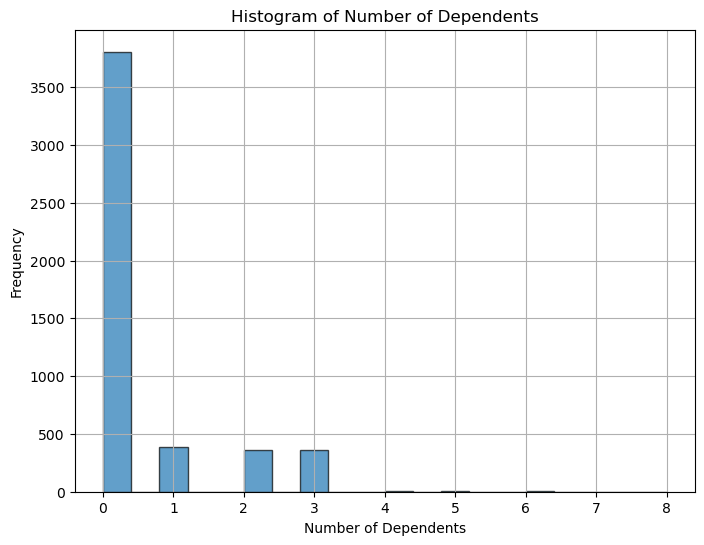

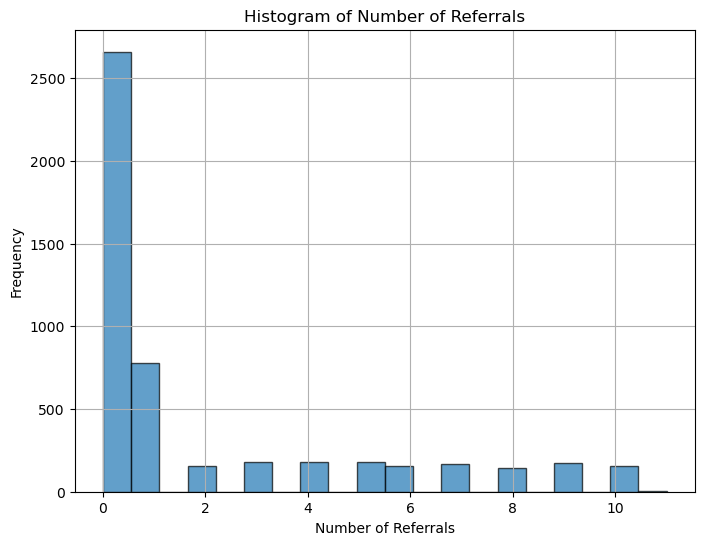

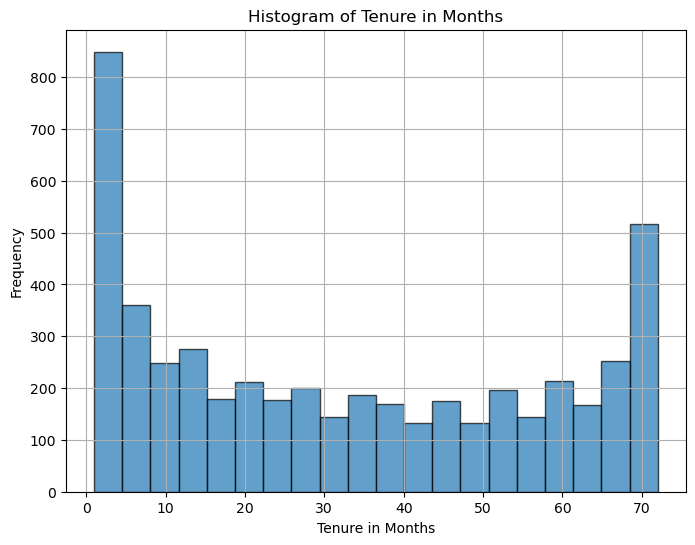

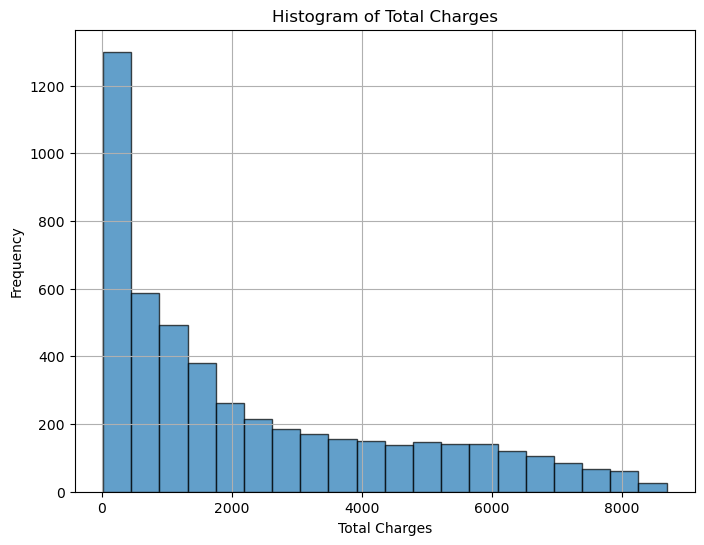

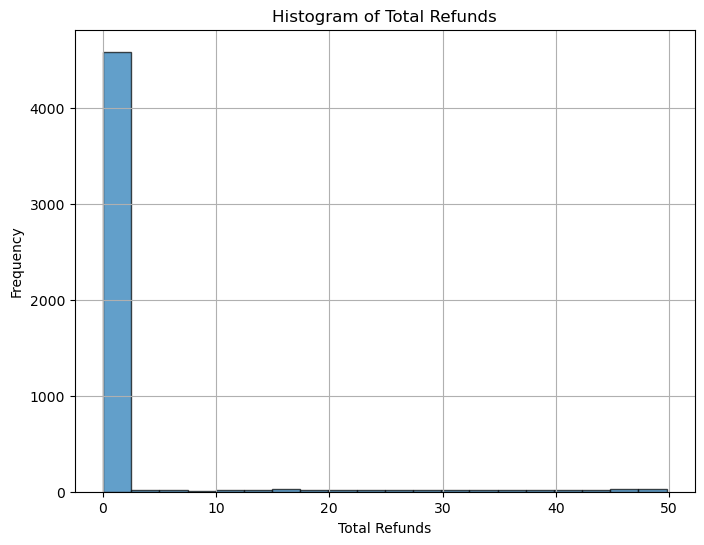

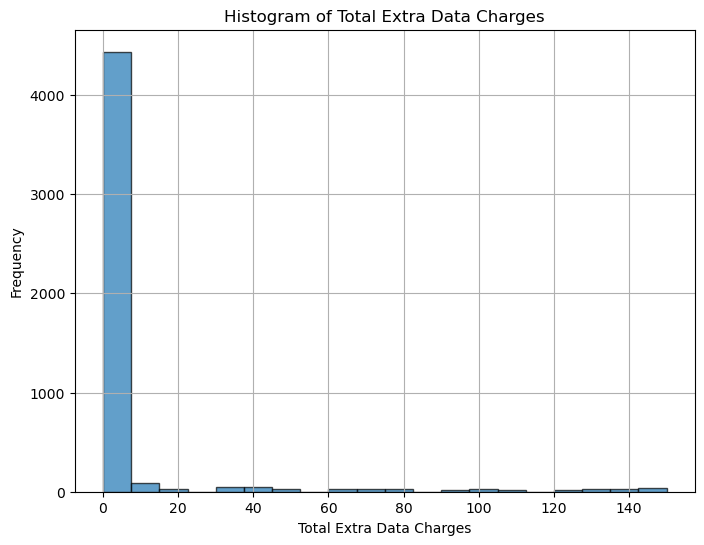

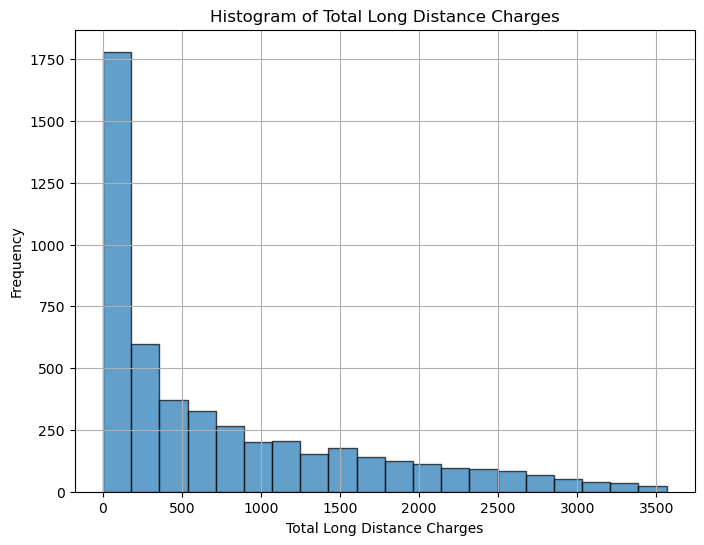

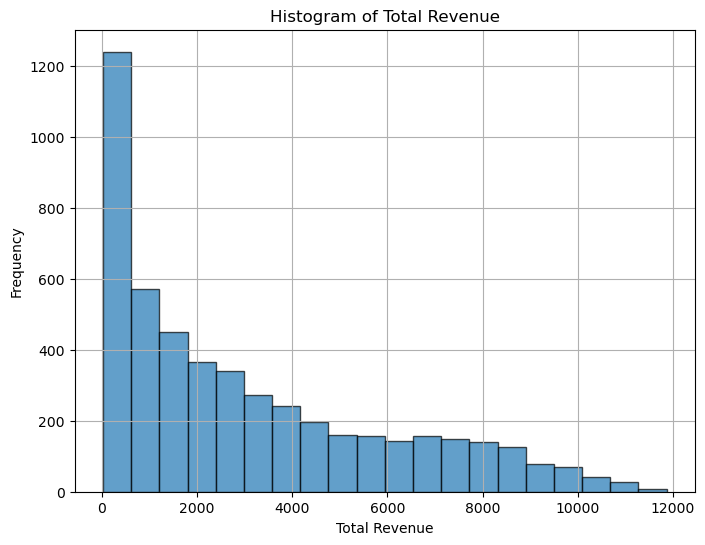

In [7]:
for col in num_cols:
    plt.figure(figsize=(8, 6))
    plt.hist(df[col], bins=20, edgecolor='k', alpha=0.7)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

Univariate analysis

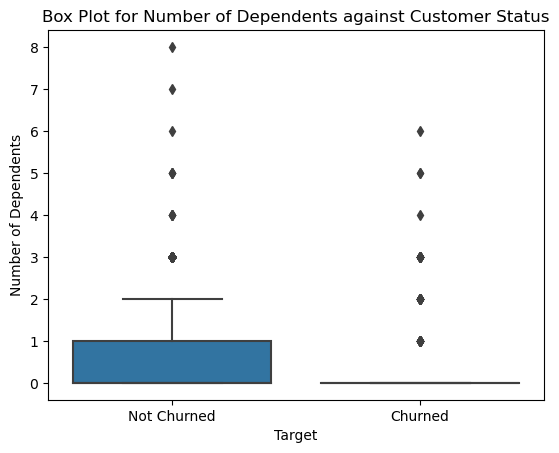

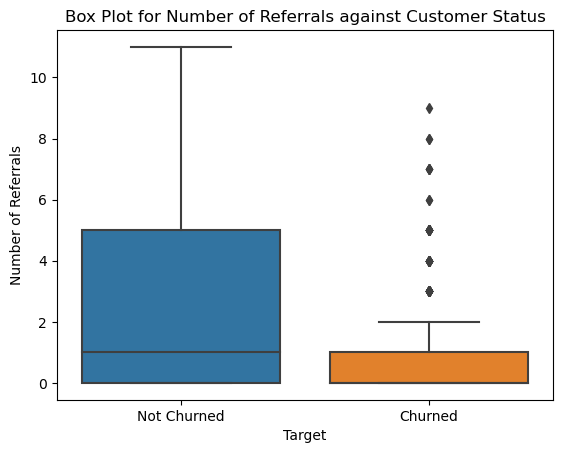

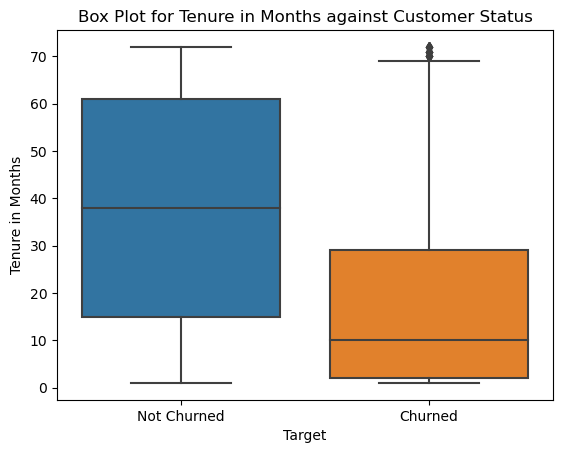

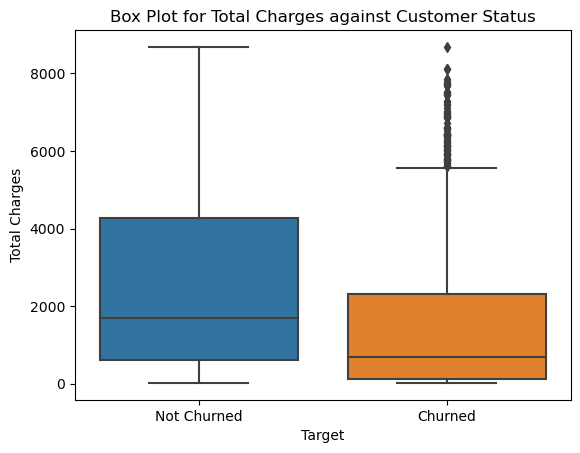

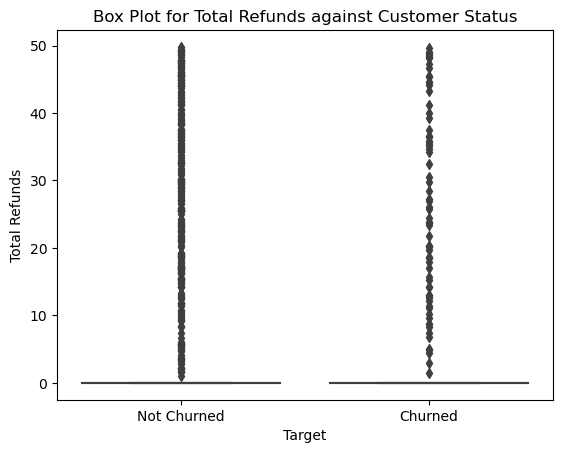

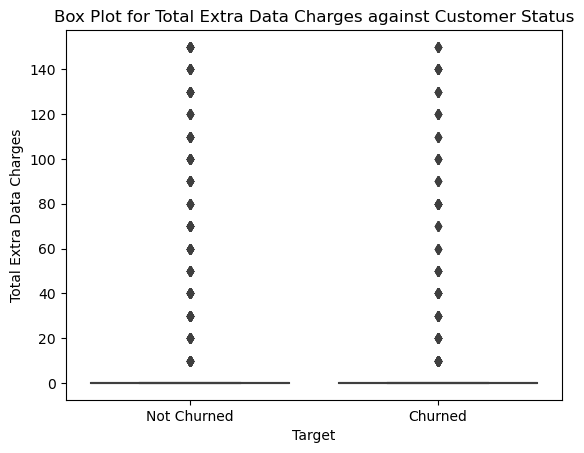

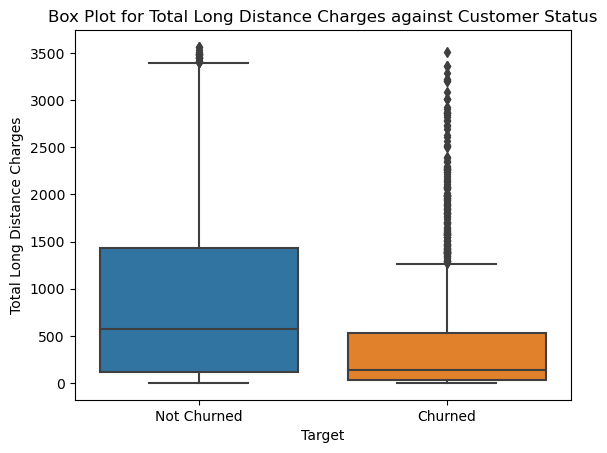

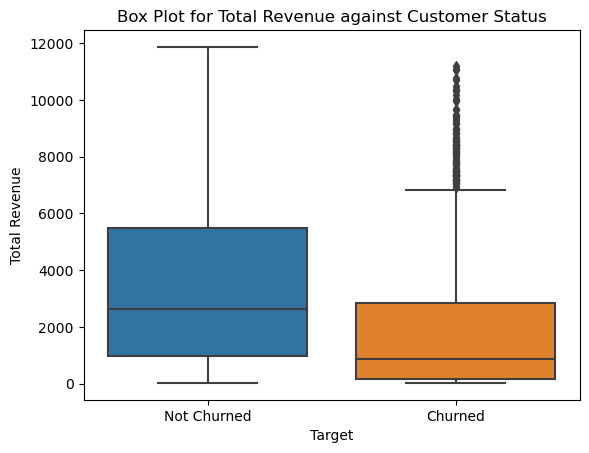

['Number of Dependents',
 'Number of Referrals',
 'Tenure in Months',
 'Total Charges',
 'Total Refunds',
 'Total Extra Data Charges',
 'Total Long Distance Charges',
 'Total Revenue']

In [8]:
# Box plots for numerical data
for column in num_cols:
    plt.figure()  # Create a new figure for each box plot
    sns.boxplot(x='Customer Status', y=column, data=df)
    plt.title(f'Box Plot for {column} against {"Customer Status"}')
    plt.ylabel(column)
    plt.xlabel('Target')
    plt.show()

num_cols


#### 2.1.2 Categorical data

  



Distribution

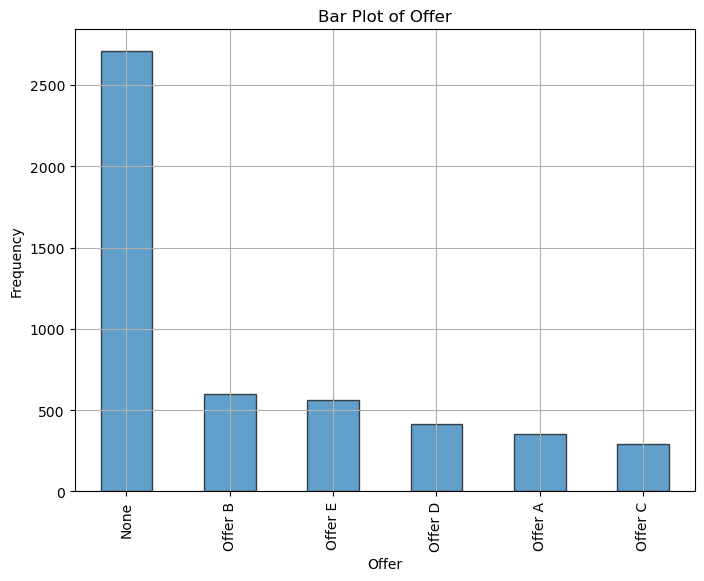

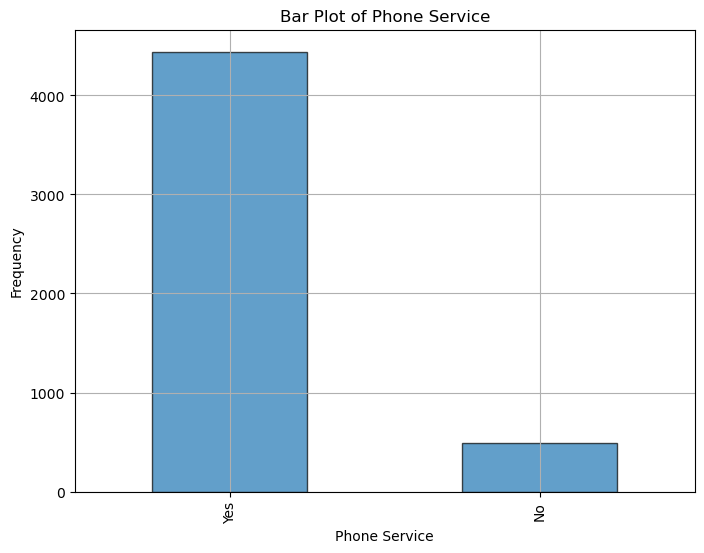

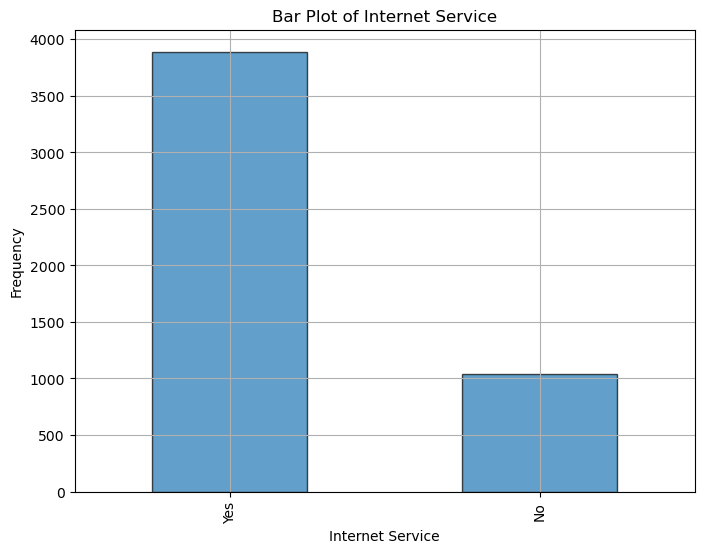

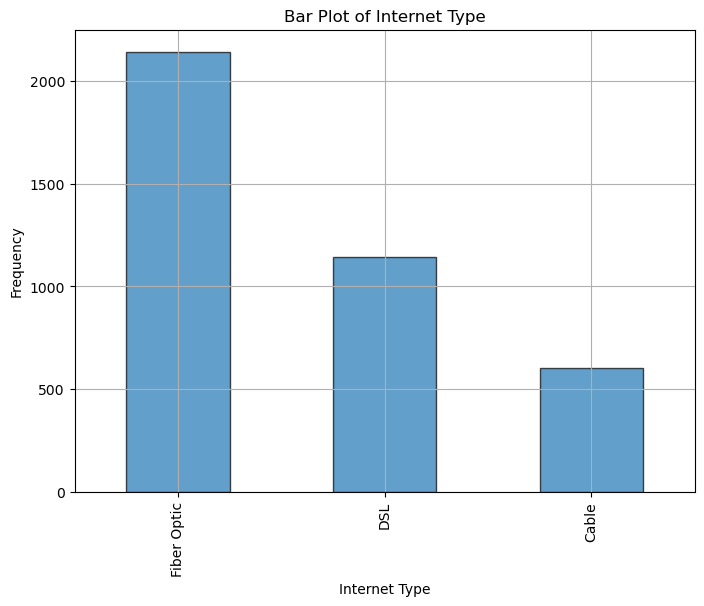

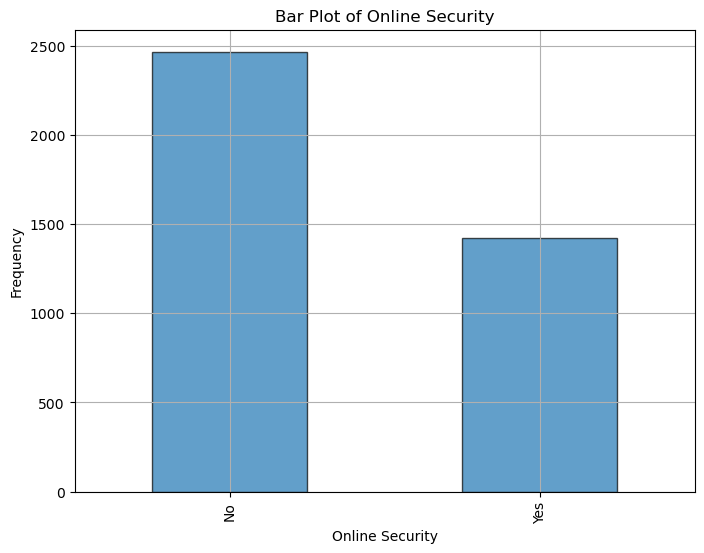

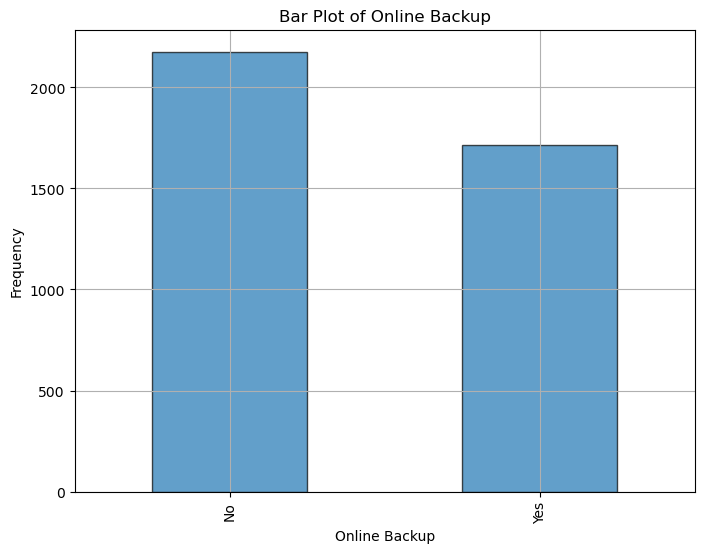

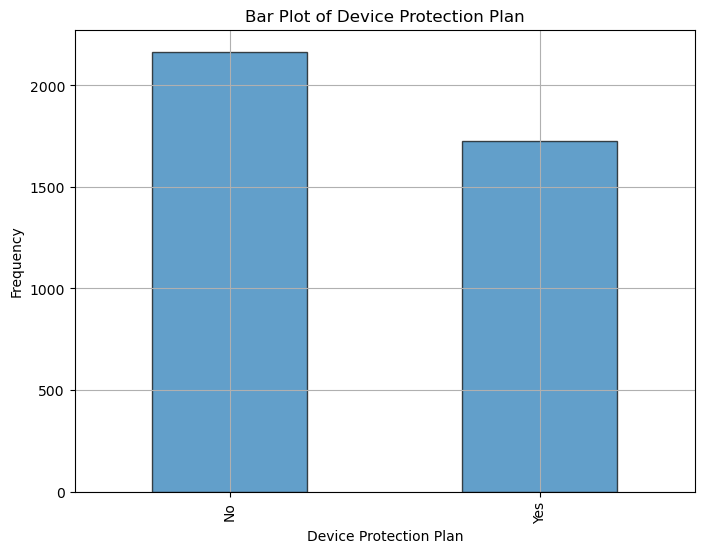

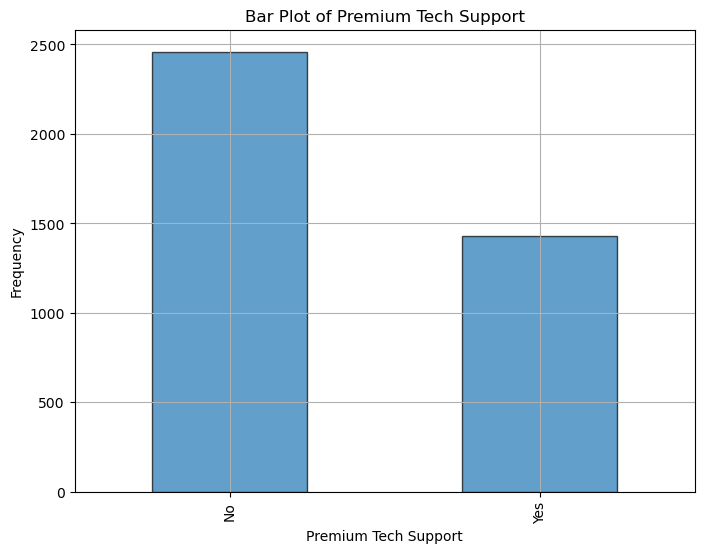

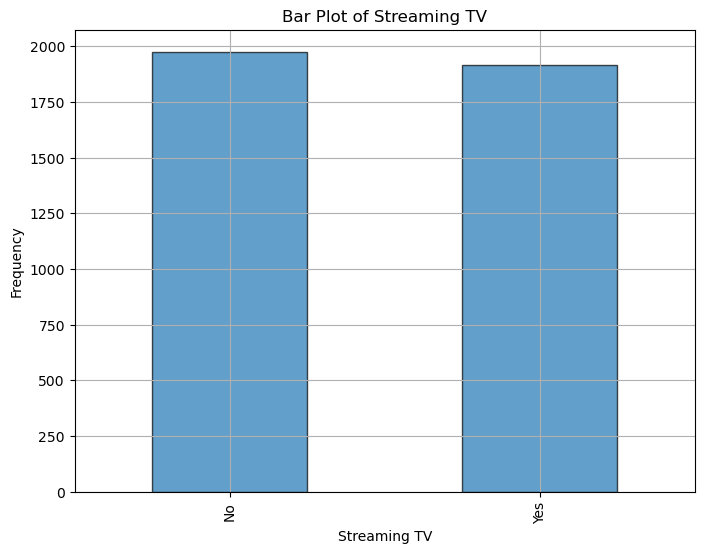

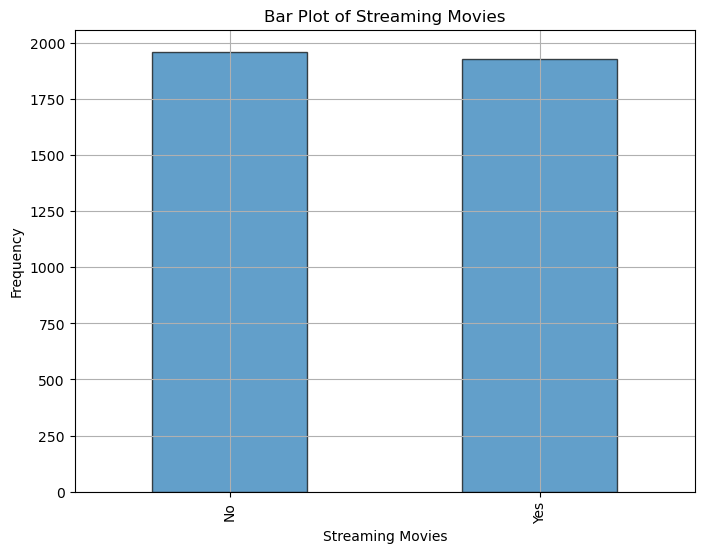

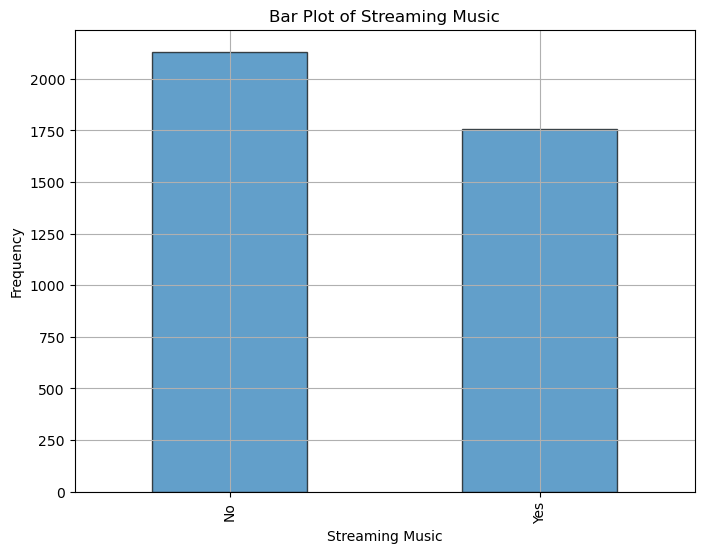

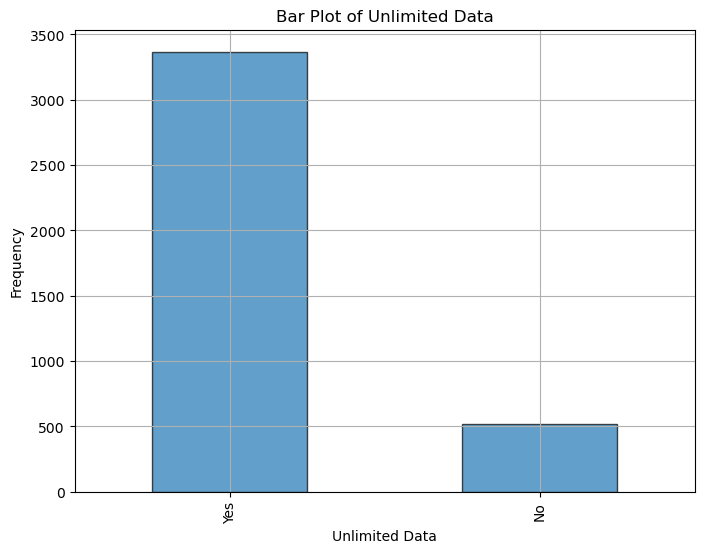

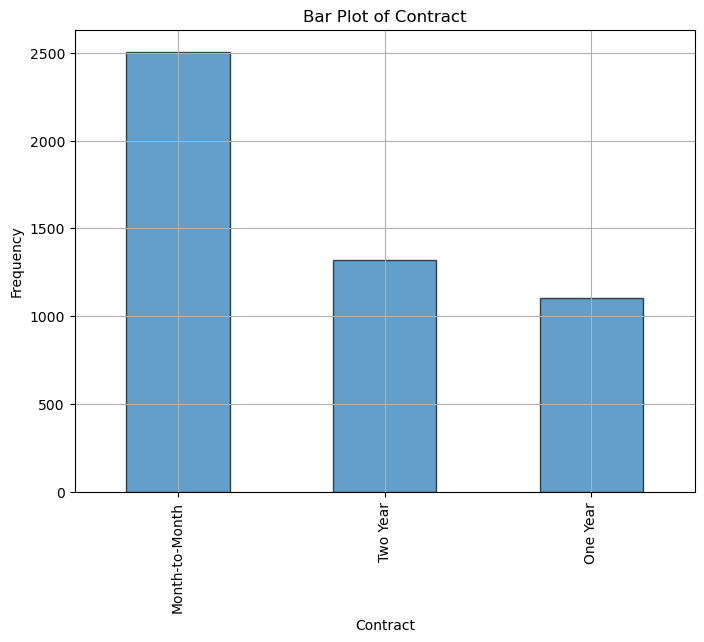

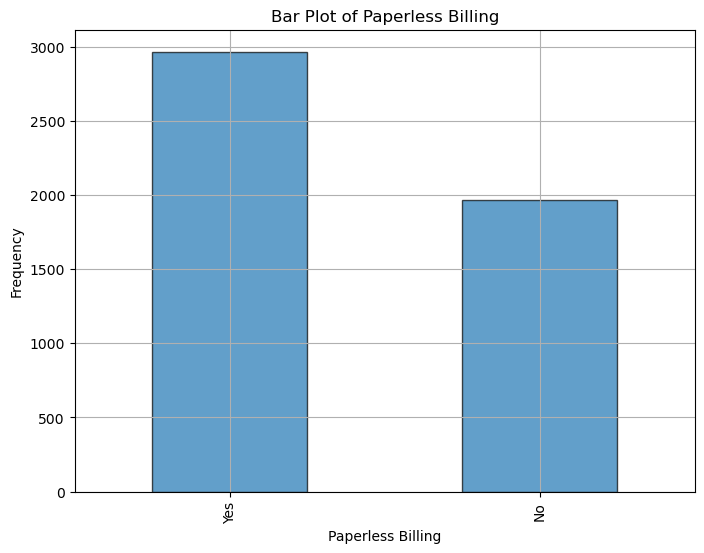

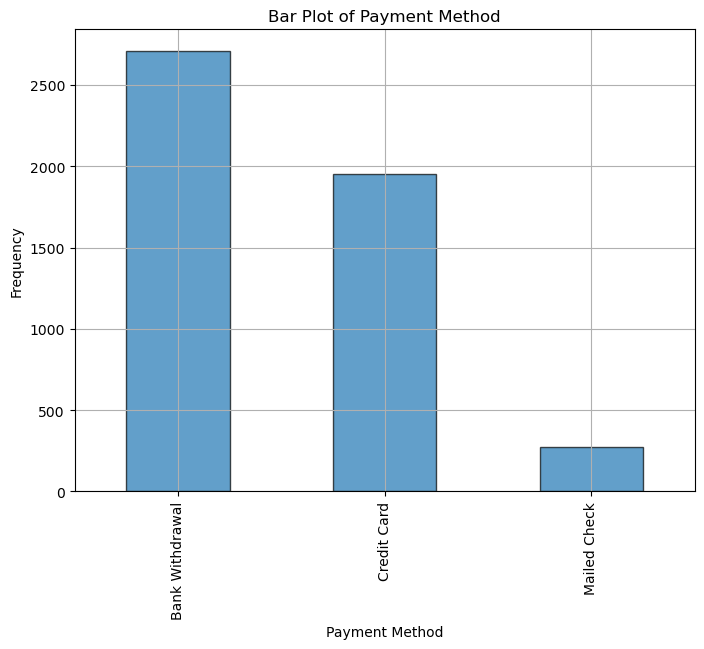

In [9]:
for col in cat_cols:
    plt.figure(figsize=(8, 6))
    cat_counts = df[col].value_counts()
    cat_counts.plot(kind='bar', edgecolor='k', alpha=0.7)
    plt.title(f'Bar Plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

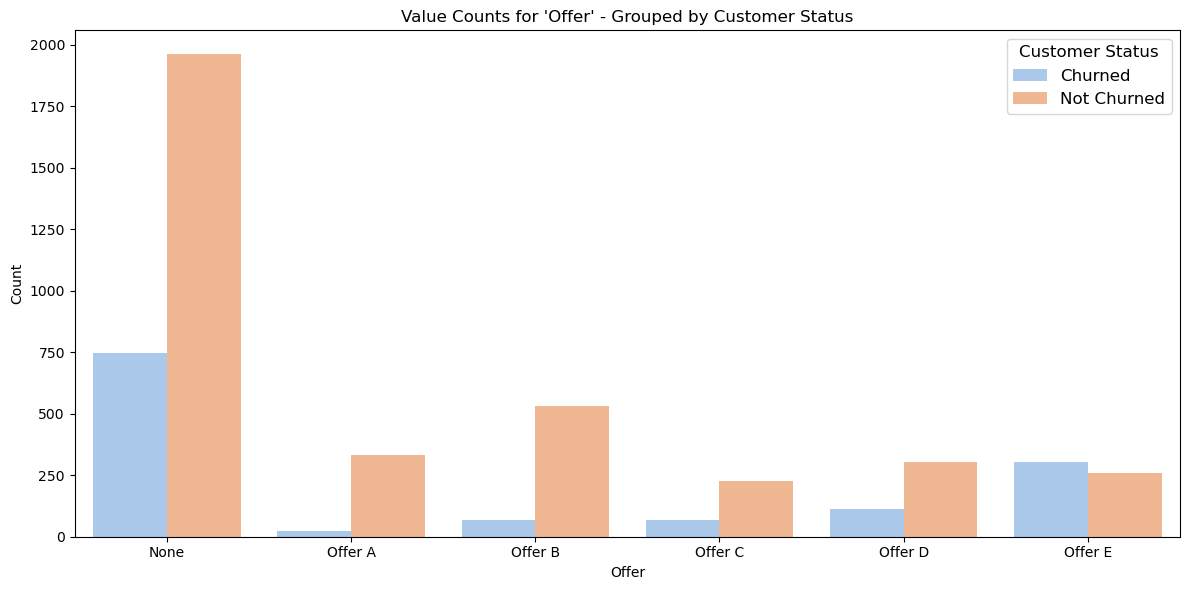

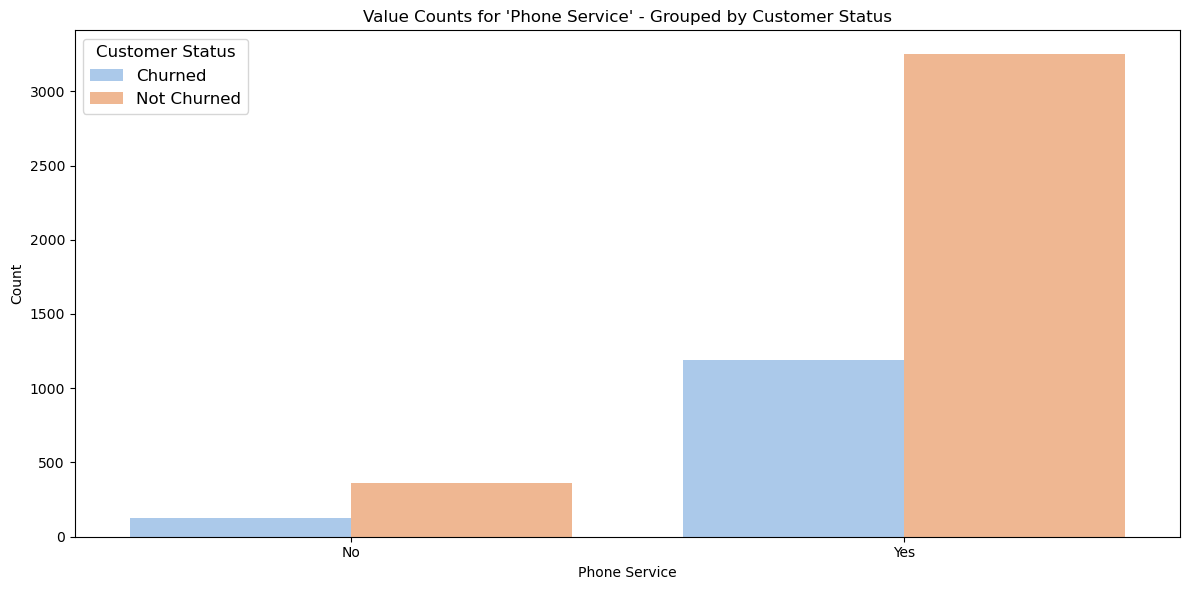

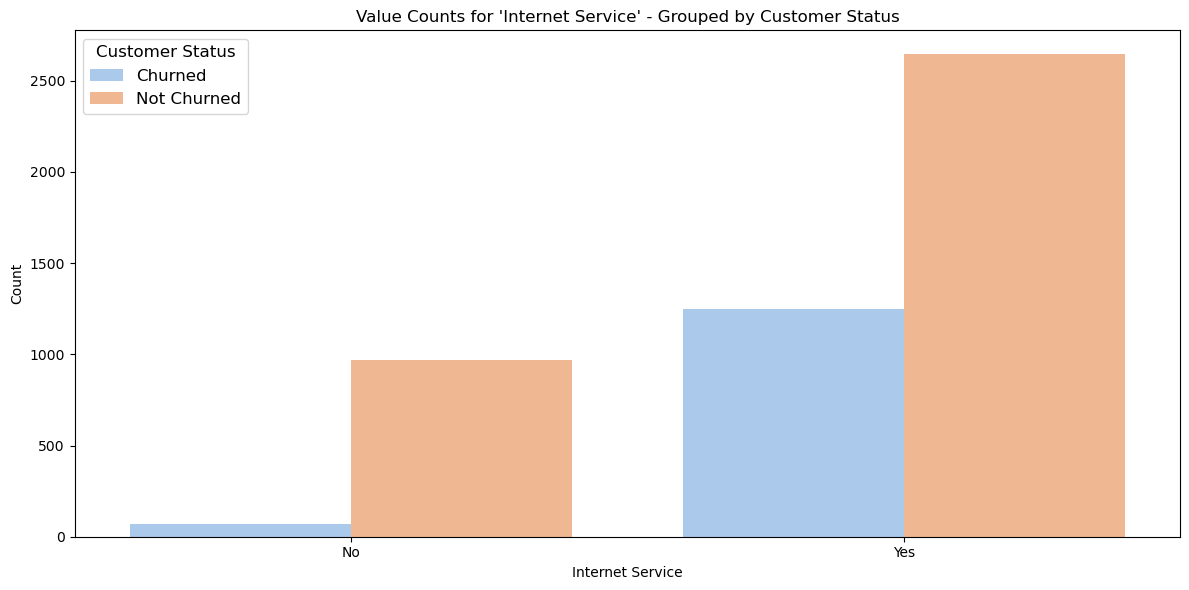

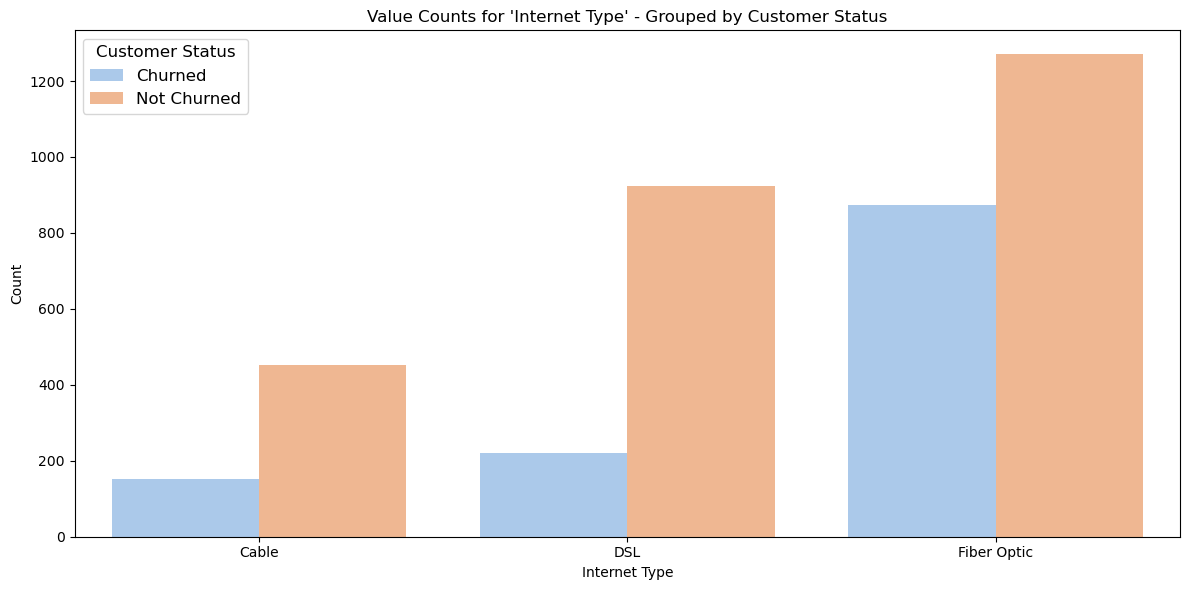

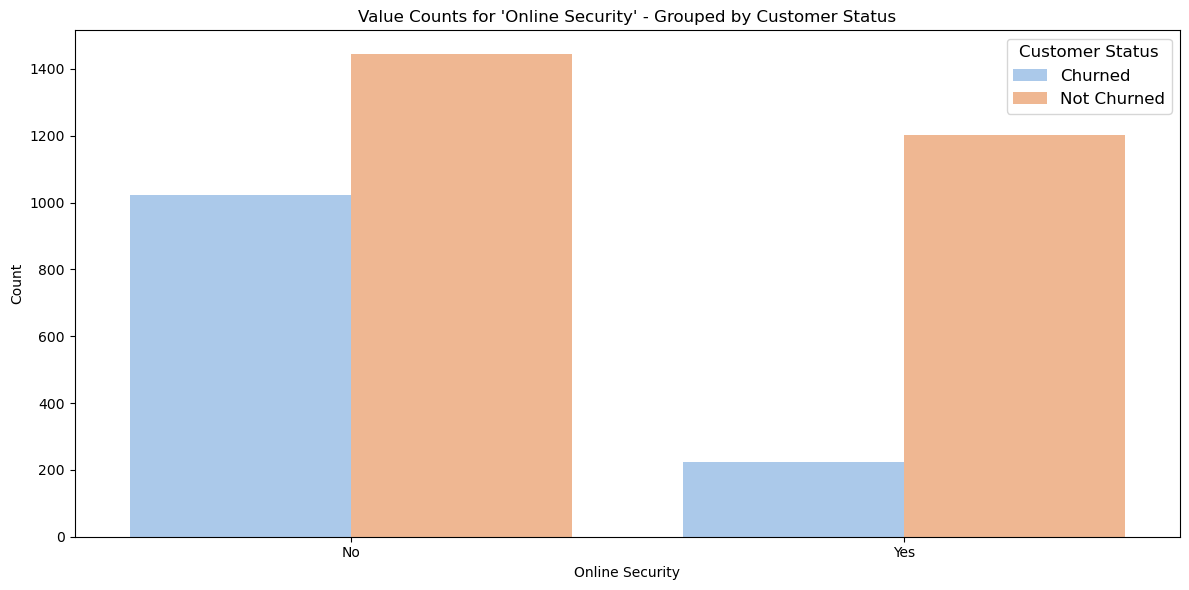

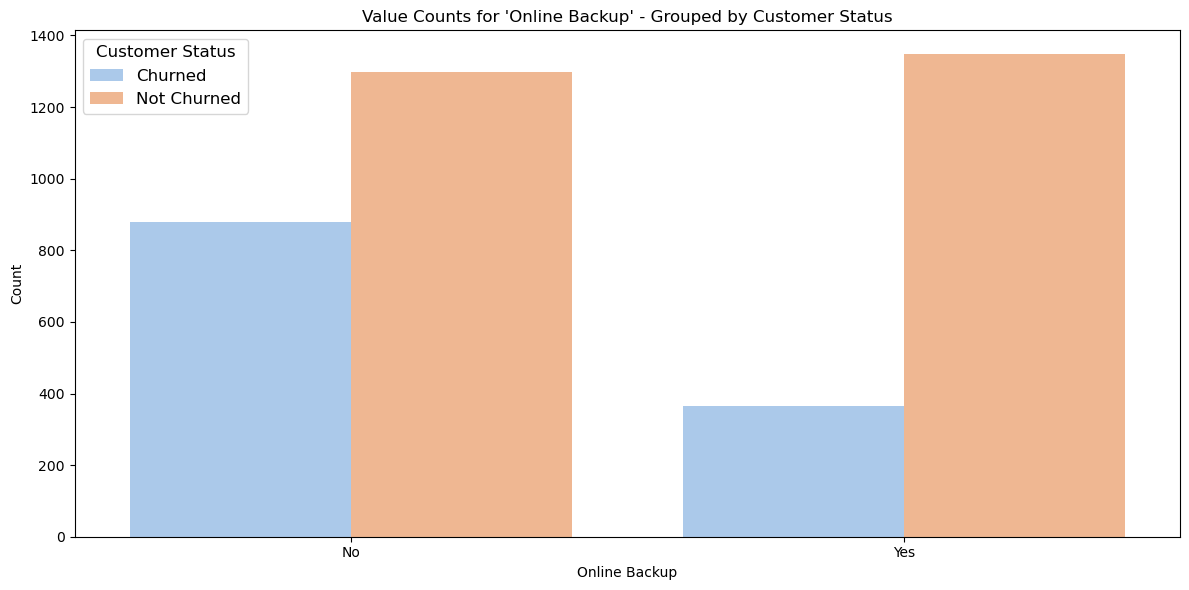

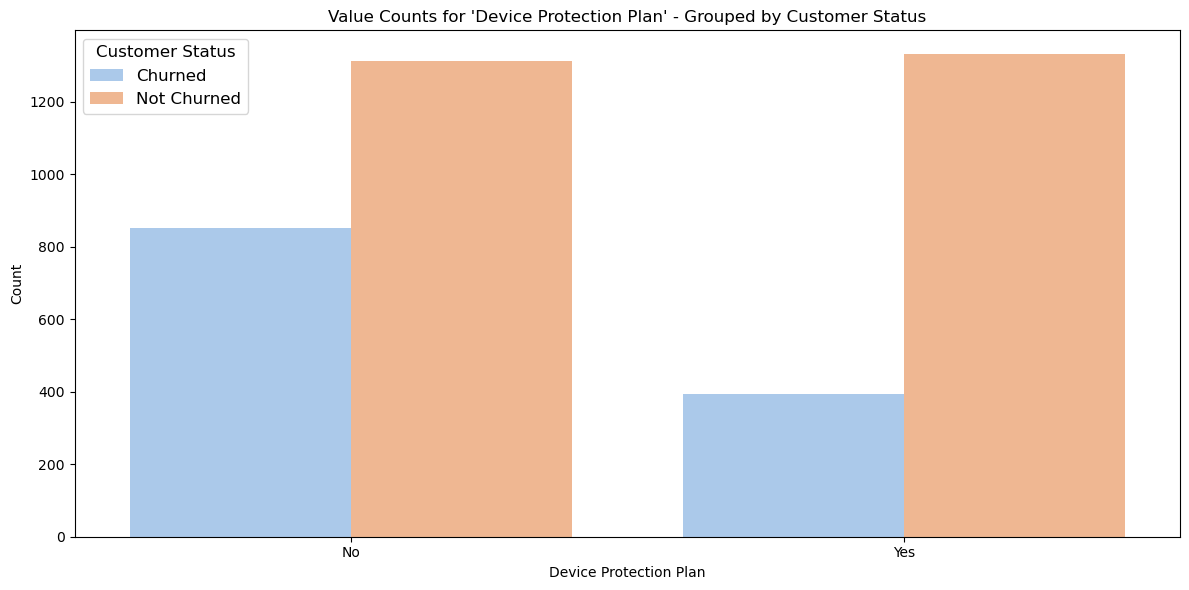

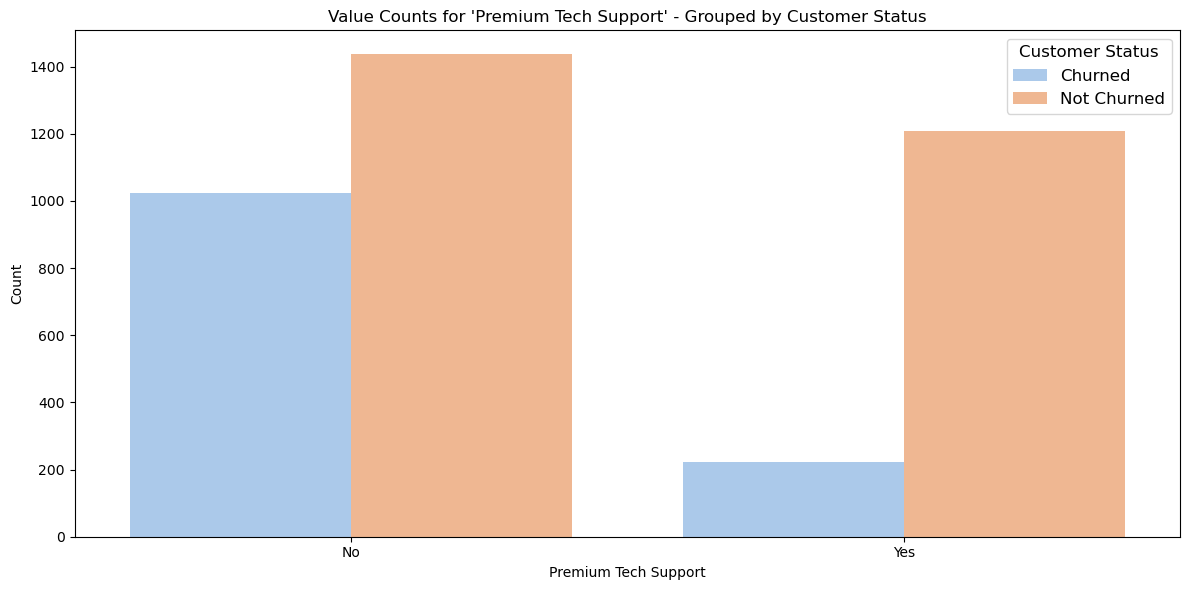

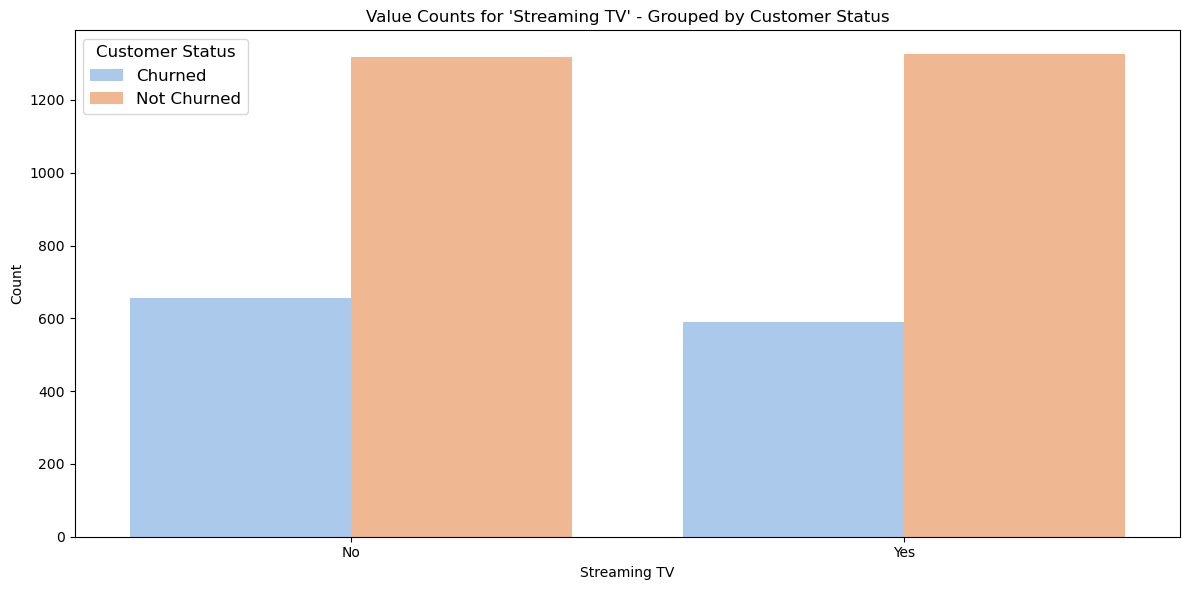

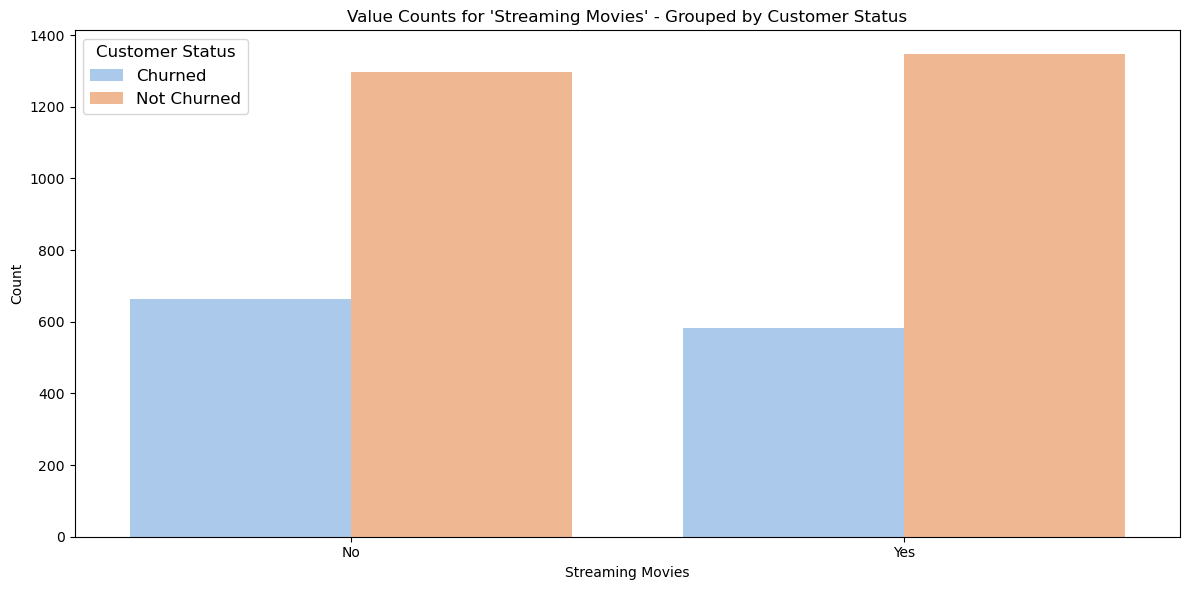

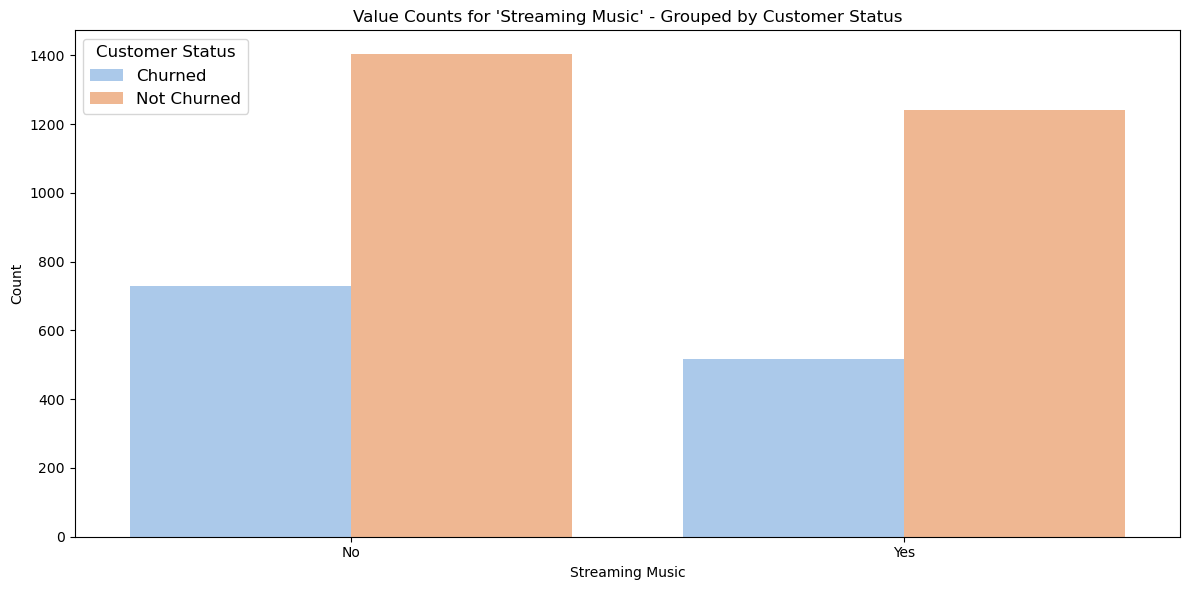

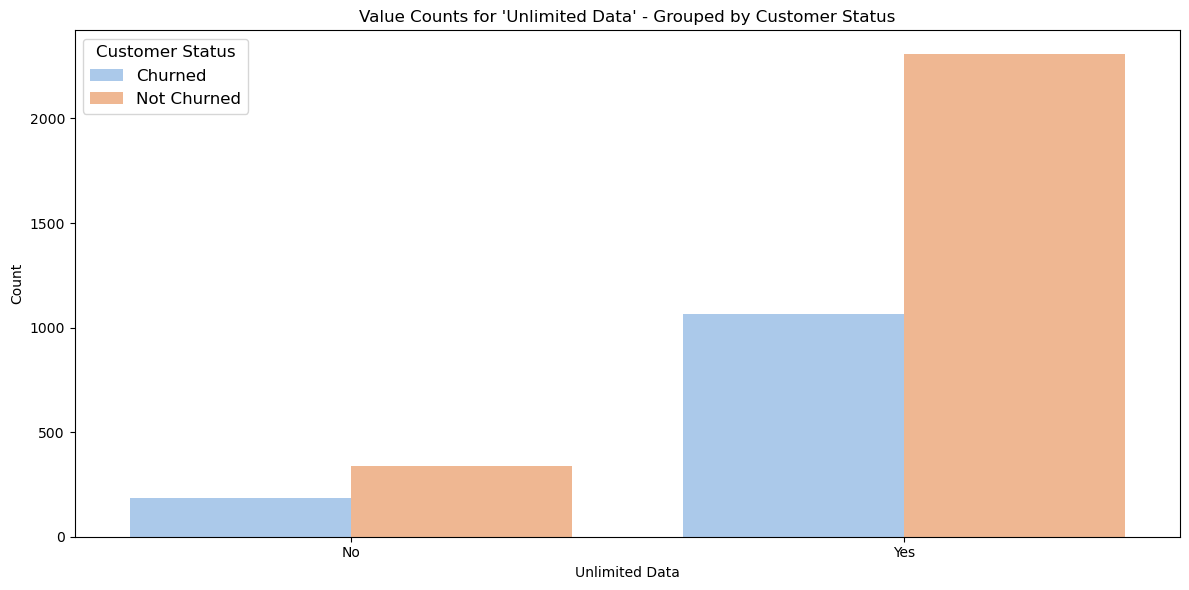

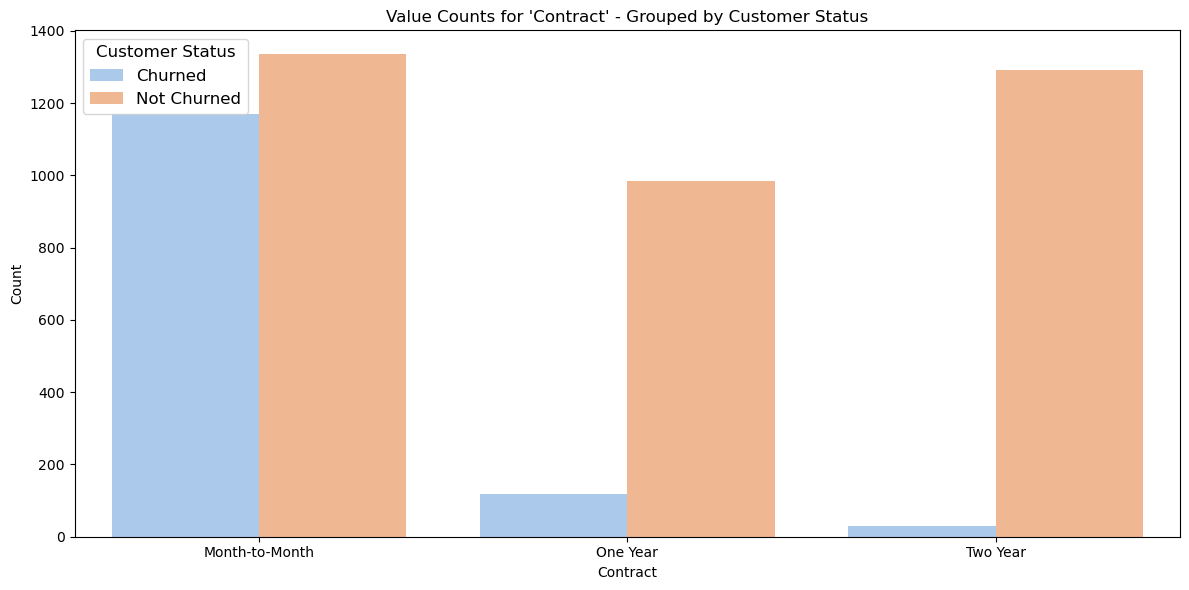

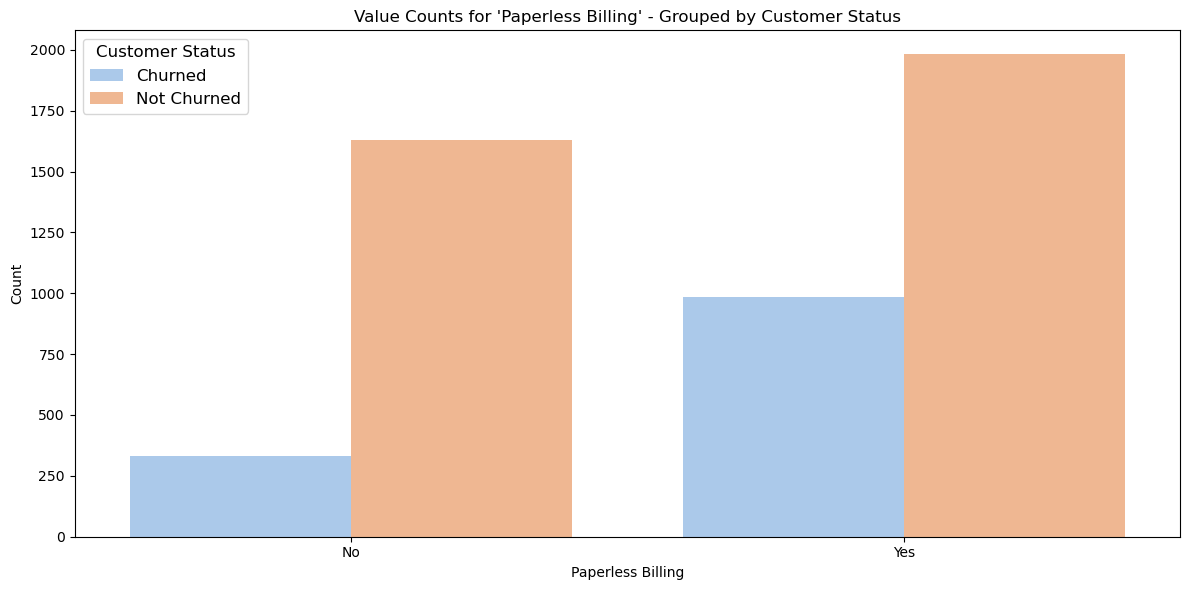

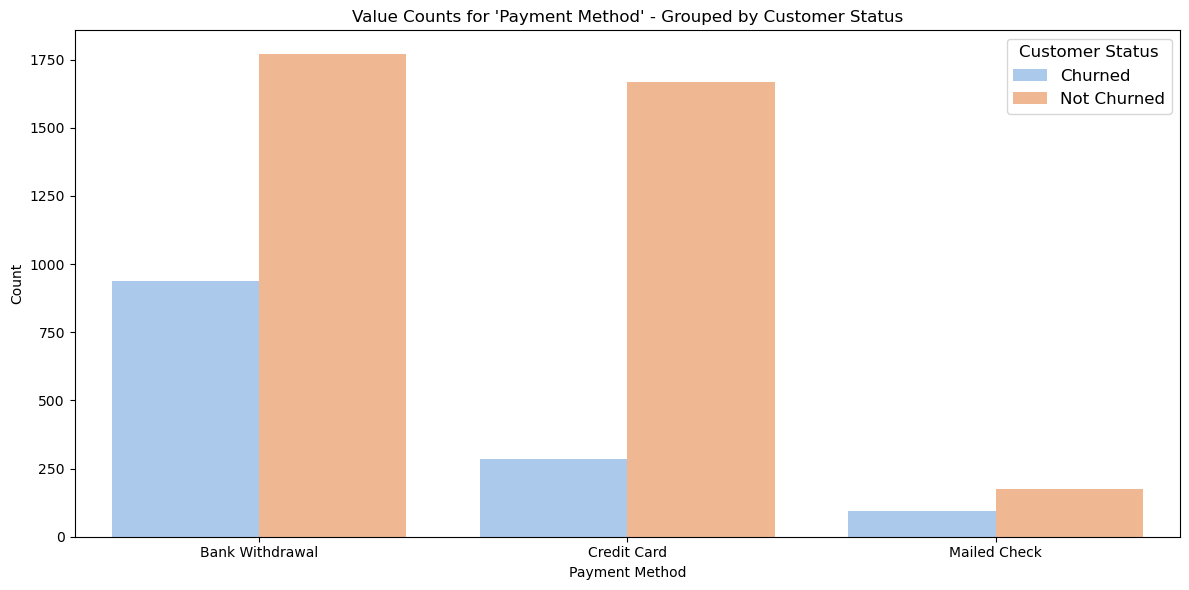

In [10]:
# Group by 'Customer Status' and each categorical column, and get value counts for each category
for col in cat_cols:
    plt.figure(figsize=(12, 6))
    plt.title(f"Value Counts for '{col}' - Grouped by Customer Status")

    # Group the data by 'Customer Status' and the current column, and get value counts for each category
    group_counts = df.groupby(['Customer Status', col]).size().unstack()

    # Plot the grouped bar chart
    sns.barplot(data=group_counts.reset_index().melt(id_vars='Customer Status', value_name='Count'),
                x=col, y='Count', hue='Customer Status', palette='pastel')

    # Set labels and legend
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend(title='Customer Status', title_fontsize='large', fontsize='large')

    plt.tight_layout()
    plt.show()

### 2.2 Data preprocessing


In [11]:
df

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.60,593.30,0.00,0,381.51,974.81,Not Churned,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.00,542.40,38.33,10,96.21,610.28,Not Churned,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.90,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.00,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.90,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9987-LUTYD,Female,20,No,0,La Mesa,91941,32.759327,-116.997260,0,...,Credit Card,55.15,742.90,0.00,0,606.84,1349.74,Not Churned,NaN,NaN
7039,9992-RRAMN,Male,40,Yes,0,Riverbank,95367,37.734971,-120.954271,1,...,Bank Withdrawal,85.10,1873.70,0.00,0,356.40,2230.10,Churned,Dissatisfaction,Product dissatisfaction
7040,9992-UJOEL,Male,22,No,0,Elk,95432,39.108252,-123.645121,0,...,Credit Card,50.30,92.75,0.00,0,37.24,129.99,Not Churned,NaN,NaN
7041,9993-LHIEB,Male,21,Yes,0,Solana Beach,92075,33.001813,-117.263628,5,...,Credit Card,67.85,4627.65,0.00,0,142.04,4769.69,Not Churned,NaN,NaN


In [12]:
df


,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.60,593.30,0.00,0,381.51,974.81,Not Churned,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.00,542.40,38.33,10,96.21,610.28,Not Churned,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.90,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.00,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.90,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9987-LUTYD,Female,20,No,0,La Mesa,91941,32.759327,-116.997260,0,...,Credit Card,55.15,742.90,0.00,0,606.84,1349.74,Not Churned,NaN,NaN
7039,9992-RRAMN,Male,40,Yes,0,Riverbank,95367,37.734971,-120.954271,1,...,Bank Withdrawal,85.10,1873.70,0.00,0,356.40,2230.10,Churned,Dissatisfaction,Product dissatisfaction
7040,9992-UJOEL,Male,22,No,0,Elk,95432,39.108252,-123.645121,0,...,Credit Card,50.30,92.75,0.00,0,37.24,129.99,Not Churned,NaN,NaN
7041,9993-LHIEB,Male,21,Yes,0,Solana Beach,92075,33.001813,-117.263628,5,...,Credit Card,67.85,4627.65,0.00,0,142.04,4769.69,Not Churned,NaN,NaN


In [13]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Define the features and label
features = cat_cols + num_cols
label = 'Customer Status'

# Convert the label column to ordinal categories
label_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
y = label_encoder.fit_transform(df[label].values.reshape(-1, 1))


# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df[features], y, test_size=0.3, random_state=0)

# Define a pipeline for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Define a pipeline for categorical columns
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Create a ColumnTransformer to apply the pipeline to the numeric and categorical columns
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

# Fit the preprocessor to the training data and transform both the training and test data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print('Training Set: %d, Test Set: %d \n' % (len(X_train), len(X_test)))

# Print the transformed DataFrames
print("X_train_Transformed:\n", X_train_transformed)
print("\nX_test_Transformed:\n", X_test_transformed)


# Create a dictionary to map encoded variables to original labels
label_mapping = {}
for i, label in enumerate(label_encoder.categories_[0]):
    label_mapping[i] = label

# Print the dictionary
print("Encoded to Original Label Mapping:")
print(label_mapping)


Training Set: 3451, Test Set: 1479 

X_train_Transformed:
 [[-0.48082285 -0.65453894 -1.28106541 ...  2.          1.
   0.        ]
 [-0.48082285  1.65948084  1.1052522  ...  2.          0.
   0.        ]
 [ 2.75371838 -0.65453894 -1.28106541 ...  0.          0.
   0.        ]
 ...
 [-0.48082285 -0.65453894 -1.24061935 ...  0.          0.
   0.        ]
 [ 1.67553797 -0.32396469 -0.14857569 ...  0.          1.
   1.        ]
 [ 2.75371838 -0.65453894 -0.91705086 ...  0.          0.
   1.        ]]

X_test_Transformed:
 [[-0.48082285 -0.65453894 -1.28106541 ...  0.          1.
   0.        ]
 [-0.48082285 -0.65453894  1.30748251 ...  2.          0.
   0.        ]
 [-0.48082285 -0.32396469 -0.31035994 ...  0.          1.
   0.        ]
 ...
 [-0.48082285  0.99833233  1.30748251 ...  2.          0.
   1.        ]
 [-0.48082285 -0.65453894 -0.02723751 ...  0.          1.
   1.        ]
 [-0.48082285 -0.65453894  1.42882069 ...  2.          0.
   1.        ]]
Encoded to Original Label Mappi

In [14]:
#Save preprocessor as pickle file

import joblib 
joblib.dump(preprocessor, "preprocessor.pkl")

['preprocessor.pkl']

## 3. Model Selection


In [15]:
#Import classifier
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=1).fit(X_train_transformed, y_train)  # Convert one-hot encoded y_train to 1D array


#Model evaluation
#from preprolib.myfunctions import evaluate_model

#evaluate_model(rf_model,X_test_transformed, y_test)



C:\Users\User\AppData\Local\Temp\ipykernel_3180\3155336143.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model = RandomForestClassifier(random_state=1).fit(X_train_transformed, y_train)  # Convert one-hot encoded y_train to 1D array


In [16]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
#Convert the one-hot encoded y_test to a 1-dimensional array
y_test = y_test

predictions = rf_model.predict(X_test_transformed)


#Calculate the necessary metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')
f1 = f1_score(y_test, predictions, average='weighted')

#Print the results for the current model
print("Model Evaluation:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

#evaluate_model(rf_model,X_test_transformed, y_test)


Model Evaluation:
Accuracy: 0.8248816768086545
Precision: 0.8192510046389897
Recall: 0.8248816768086545
F1-score: 0.8207080313395132


In [17]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation with 5 folds (you can adjust the number of folds as needed)

cv_scores = cross_val_score(rf_model, X_train_transformed, y_train, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation Scores:", cv_scores)
print("Average Cross-validation Accuracy:", cv_scores.mean())


c:\Users\User\.conda\envs\NewEnv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\User\.conda\envs\NewEnv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\User\.conda\envs\NewEnv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\User\.conda\envs\NewEnv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConvers

Cross-validation Scores: [0.82344428 0.84057971 0.81884058 0.81014493 0.83913043]
Average Cross-validation Accuracy: 0.8264279871641603


In [18]:
import plotly.express as px
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

# Reshape the test_pred array to a 2D array
predictions = predictions.reshape(-1, 1)

predictions = label_encoder.inverse_transform(predictions)



In [19]:
# Reshape the test_pred array to a 2D array
y_test = y_test.reshape(-1, 1)

y_test = label_encoder.inverse_transform(y_test)

In [20]:
y_test

array([['Churned'],
       ['Not Churned'],
       ['Churned'],
       ...,
       ['Not Churned'],
       ['Churned'],
       ['Not Churned']], dtype=object)

In [21]:
# Calculate the confusion matrix
confusion = confusion_matrix(y_test, predictions)

# Create a DataFrame from the confusion matrix
confusion_df = pd.DataFrame(confusion, index=["Actual " + str(label) for label in np.unique(y_test)], columns=["Predicted " + str(label) for label in np.unique(y_test)])

# Define a custom blue color scale with increasing darkness
color_scale = [[0, '#FFFFFF'], [0.1, '#D9F0FF'], [0.5, '#77B2E5'], [1, '#003399']]

# Create a confusion matrix heatmap using Plotly with the custom color scale
fig = px.imshow(confusion_df, title="Confusion Matrix", color_continuous_scale=color_scale)
fig.update_xaxes(title_text="Predicted Labels")
fig.update_yaxes(title_text="Actual Labels")

# Show the confusion matrix plot
fig.show()


In [22]:
    feature_importance = rf_model.feature_importances_

    # Combine feature names and their importance scores
    feature_importance_data = pd.DataFrame({'Feature': features, 'Importance': feature_importance})

    # Sort the features by importance (descending order)
    feature_importance_data = feature_importance_data.sort_values(by='Importance', ascending=False)

    # Create a bar chart to visualize feature importance
    fig = px.bar(
        feature_importance_data,
        x='Feature',
        y='Importance',
        title='Feature Importance',
    )

In [28]:
fig

In [23]:
import joblib

# Save the model to a file
joblib.dump(rf_model, 'trained_rf_model.pkl')

print("Model saved successfully.")



Model saved successfully.


In [24]:
# Load the model from the file
loaded_rf_model = joblib.load('trained_rf_model.pkl')

# Transform the test data using the preprocessor
df_test_transformed = preprocessor.transform(df_test)

# Make predictions on the test data using the loaded model
test_pred = loaded_rf_model.predict(df_test_transformed)

# Reshape the test_pred array to a 2D array
test_pred_2d = test_pred.reshape(-1, 1)

# Map the predicted values back to their original labels
predicted_labels = label_encoder.inverse_transform(test_pred_2d)

# Print the predicted labels
print("Predicted Labels:")
print(predicted_labels)



Predicted Labels:
[['Not Churned']
 ['Not Churned']
 ['Not Churned']
 ...
 ['Churned']
 ['Churned']
 ['Not Churned']]


In [25]:
# Create a new DataFrame with the predicted labels
predicted_df = pd.DataFrame(predicted_labels, columns=['Predicted_Customer_Status'])

# Concatenate the predicted_df with df_test
df_test_with_predictions = pd.concat([df_test, predicted_df], axis=1)

# Print the DataFrame with the predicted labels
print(df_test_with_predictions)


     Customer ID  Gender   Age Married  Number of Dependents           City  \
185   0301-KOBTQ    Male  50.0      No                   0.0       Capitola   
2715  3865-YIOTT    Male  40.0     Yes                   1.0  San Francisco   
3825  5377-NDTOU  Female  26.0     Yes                   0.0      San Pedro   
1807  2637-FKFSY  Female  61.0     Yes                   0.0          Wasco   
132   0224-NIJLP    Male  30.0     Yes                   3.0        Turlock   
...          ...     ...   ...     ...                   ...            ...   
2105         NaN     NaN   NaN     NaN                   NaN            NaN   
2106         NaN     NaN   NaN     NaN                   NaN            NaN   
2108         NaN     NaN   NaN     NaN                   NaN            NaN   
2109         NaN     NaN   NaN     NaN                   NaN            NaN   
2111         NaN     NaN   NaN     NaN                   NaN            NaN   

      Zip Code   Latitude   Longitude  Number of Re

In [26]:
df_test_with_predictions.loc[:,'Predicted_Customer_Status']

185     Not Churned
2715            NaN
3825            NaN
1807    Not Churned
132     Not Churned
           ...     
2105        Churned
2106    Not Churned
2108    Not Churned
2109    Not Churned
2111        Churned
Name: Predicted_Customer_Status, Length: 3573, dtype: object

In [27]:
df_test_with_predictions.columns

Index(['Customer ID', 'Gender', 'Age', 'Married', 'Number of Dependents',
       'City', 'Zip Code', 'Latitude', 'Longitude', 'Number of Referrals',
       'Tenure in Months', 'Offer', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue', 'Predicted_Customer_Status'],
      dtype='object')